In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# pip install plot-keras-history
# https://pypi.org/project/plot-keras-history/
from plot_keras_history import show_history, plot_history

# Import our dataset
#loan_df = pd.read_csv('Data_Source/loan.csv')              # <-- original dataset with excess columns and dates from 2015-2018
loan_df = pd.read_csv('Data_Source/LC_loans_2017-2018.csv') # <-- trimmed dataset with data exclusively from 2017 and 2018 - the most recent years available

#loan_df.head()

In [2]:
# round interest rate to whole number to measure accuracy to the nearest 0.5%
    # has been tested, with no real improvement because of the scale of the dataset

# loan_df_interest_rounded = list(loan_df['int_rate'])
# interest_rounded_list = []

# for number in loan_df_interest_rounded:
#     interest_rounded_list.append(round(number * 2) / 2)

# loan_df['interest_rounded'] = interest_rounded_list

# Predicting Grade
This section contains fully commented testing code in addition to the fully functional model

In [2]:
# split into labels and features

y = loan_df['grade']           # use either grade or sub_grade
#y = loan_df['sub_grade']

# in X, *always* keep 'annual_inc', 'dti', 'loan_amnt', 'term' - thanks Jerry!
X = loan_df[['home_ownership', 'annual_inc', 'loan_amnt', 'term', 'dti', 'open_acc',
             'pub_rec', 'loan_status', 'revol_util', 'acc_now_delinq']] # 'revol_util', 'acc_now_delinq'

# removed ['mort_acc', 'emp_length', 'tot_cur_bal'] to work with the trimmed data file

In [4]:
# find rows with null values in specific columns
#X.query('annual_inc != annual_inc') # 'column_name != column_name' shows where NaNs exist

In [5]:
# drop the 4 nulls from annual_inc
#X = X.drop(index=[2141934, 2141935, 2141965, 2142018])
#y = y.drop(index=[2141934, 2141935, 2141965, 2142018])

    # this and previous cell updated to use the for loop below

In [3]:
# drop rows with null values in any column - will be around 2000 rows

# get column names from X
column_names = X.columns

# loop through X to drop the rows that have nulls and apply the same drops to y
for column in column_names:
    # temp list to hold index values that have nulls in each column
    null_list = list(X.query(f'{column} != {column}').index)
    # drop from X
    X = X.dropna(axis='index', subset=[f'{column}'])
    # drop from y
    y = y.drop(index=null_list)

In [7]:
# # drop nulls - not all columns have nulls so these are the ones that do
# dti_null_list = list(X.query('dti != dti').index)
# X = X.dropna(axis='index', subset=['dti'])
# y = y.drop(index=dti_null_list)

# emp_length_null_list = list(X.query('emp_length != emp_length').index)
# X = X.dropna(axis='index', subset=['emp_length'])
# y = y.drop(index=emp_length_null_list)

    # updated to for loop above

In [8]:
# fillna with 0 (should only impact 'mths_since_last_delinq', leading to higher accuracy. nulls in this column hurt the accuracy a lot)
# this step needs to be done after any other dropnas
#X = X.fillna(0)

    # not necessary without this column currently

### Scale and one-hot-encode the data

In [9]:
# scale the numerical data and put it in a dataframe
scaledData = StandardScaler().fit_transform(X[['annual_inc', 'dti', 'loan_amnt', 'revol_util', 'acc_now_delinq', 'pub_rec', 'open_acc']])
scaledDF = pd.DataFrame(scaledData, columns = ['annual_inc', 'dti', 'loan_amnt', 'revol_util', 'acc_now_delinq', 'pub_rec', 'open_acc'])

In [10]:
# one-hot-encode the string data and put it in a dataframe for both 'X' and 'y'
dummiesDF_X = pd.get_dummies(X[['term', 'loan_status', 'home_ownership']], dtype='float')
dummiesDF_X = dummiesDF_X.reset_index(drop=True)

dummiesDF_y = pd.get_dummies(y)

In [11]:
# concat scaled numerical data and one-hot-encoded X data
scaledDF = pd.concat([scaledDF, dummiesDF_X], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaledDF, dummiesDF_y, random_state=1)

### Train the model

In [13]:
# create layers for the neural network model. Number of layers is subjective and should be tested with more/fewer layers and nodes.

grade_model = tf.keras.models.Sequential()
grade_model.add(tf.keras.layers.Dense(units=500, input_dim=21, activation='sigmoid'))
grade_model.add(tf.keras.layers.Dense(units=250, activation='sigmoid'))
#grade_model.add(tf.keras.layers.Dense(units=125, activation='sigmoid'))
grade_model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

In [14]:
# # lower the learning rate to prevent overfitting. overfitting was common at the default learning rate, causing accuracy to tank within 1 epoch
# learning_rate = tf.Variable(0.0001, trainable=True)
# tf.keras.backend.set_value(learning_rate, 0.0001)

    # unnecessary because adam has a built in learning rate modifier

In [15]:
# train the model and check accuracy. Top K Categorical Accuracy is also included.
    # Top K Categorical Accuracy checks the top 2 (k=2) grades in this case to measure how often the correct label is in the top 2 predictions.
grade_model.compile(loss='categorical_focal_crossentropy', optimizer='adam', metrics=['accuracy', [keras.metrics.TopKCategoricalAccuracy(k=2)]])

# test on 5 epochs
fit_grade_model = grade_model.fit(X_train, y_train, epochs=5)


Epoch 1/5


21941/21941 [==============================] - 37s 2ms/step - loss: 0.2006 - accuracy: 0.4139 - top_k_categorical_accuracy: 0.7053
Epoch 2/5
21941/21941 [==============================] - 35s 2ms/step - loss: 0.1964 - accuracy: 0.4214 - top_k_categorical_accuracy: 0.7129
Epoch 3/5
21941/21941 [==============================] - 37s 2ms/step - loss: 0.1950 - accuracy: 0.4238 - top_k_categorical_accuracy: 0.7154
Epoch 4/5
21941/21941 [==============================] - 35s 2ms/step - loss: 0.1943 - accuracy: 0.4258 - top_k_categorical_accuracy: 0.7163
Epoch 5/5
21941/21941 [==============================] - 36s 2ms/step - loss: 0.1939 - accuracy: 0.4267 - top_k_categorical_accuracy: 0.7168


In [16]:
model_loss, model_accuracy, top_k_categorical_accuracy = grade_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Top 2 Predictions Accuracy: {top_k_categorical_accuracy}")

7314/7314 - 7s - loss: 0.1933 - accuracy: 0.4284 - top_k_categorical_accuracy: 0.7174 - 7s/epoch - 903us/step
Loss: 0.19328755140304565, Accuracy: 0.4284426271915436, Top 2 Predictions Accuracy: 0.7173896431922913


In [17]:
# export model to keras file
    # using keras over hdf5 because hdf5 is now legacy
grade_model.save('Models/grade_model.keras')

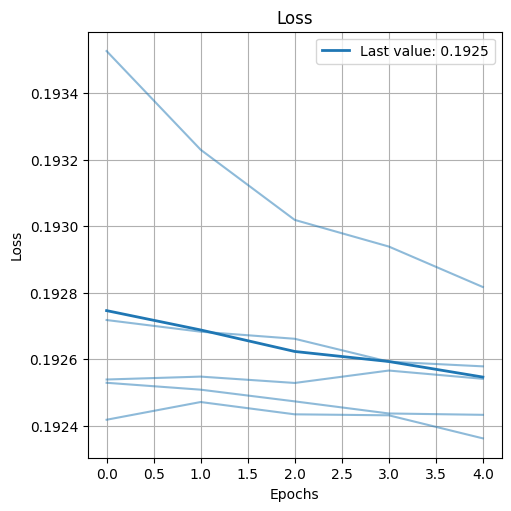

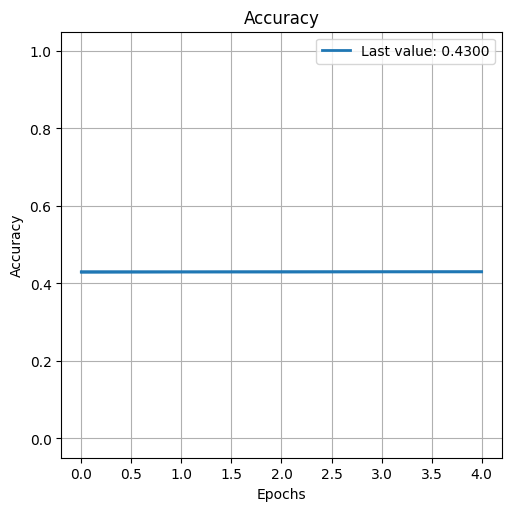

In [18]:
# use plot_keras_history to easily plot metrics scores

# list to hold histories
grade_histories = []

# loop to run training and append histories to the list
for holdout in range(5):
    model = grade_model
    grade_histories.append(model.fit(X_train, y_train, epochs=5, verbose=0))
    
# plot the histories using matplotlib
plot_history(
    grade_histories,
    path='Plots/grade_plots',
    single_graphs=True,
    show_standard_deviation=False,
    show_average=True
)

plt.close()

# Predicting Sub Grade
This section of code mirrors the Predicting Grade section and will be sparsely commented

In [45]:
# Variables 'X' and 'y' are reused to save memory. These contain the largest amounts of data after 'loan_df'
y = loan_df['sub_grade']
X = loan_df[['home_ownership', 'annual_inc', 'loan_amnt', 'term', 'dti', 'open_acc',
             'pub_rec', 'loan_status', 'revol_util', 'acc_now_delinq']]

In [46]:
column_names = X.columns
for column in column_names:
    null_list = list(X.query(f'{column} != {column}').index)
    X = X.dropna(axis='index', subset=[f'{column}'])
    y = y.drop(index=null_list)

### Scale and one-hot-encode the data

In [47]:
# 'scaledData' and 'scaledDF' are also reused to save memory.
scaledData = StandardScaler().fit_transform(X[['annual_inc', 'dti', 'loan_amnt', 'revol_util', 'acc_now_delinq', 'pub_rec', 'open_acc']])
scaledDF = pd.DataFrame(scaledData, columns = ['annual_inc', 'dti', 'loan_amnt', 'revol_util', 'acc_now_delinq', 'pub_rec', 'open_acc'])

In [48]:
dummiesDF_X = pd.get_dummies(X[['term', 'loan_status', 'home_ownership']], dtype='float')
dummiesDF_X = dummiesDF_X.reset_index(drop=True)

dummiesDF_y = pd.get_dummies(y)

In [49]:
# concat scaled numerical data and one-hot-encoded X data
scaledDF = pd.concat([scaledDF, dummiesDF_X], axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scaledDF, dummiesDF_y, random_state=1)

### Train the model

In [51]:
sub_grade_model = tf.keras.models.Sequential()
sub_grade_model.add(tf.keras.layers.Dense(units=500, input_dim=21, activation='sigmoid'))
sub_grade_model.add(tf.keras.layers.Dense(units=250, activation='sigmoid'))
sub_grade_model.add(tf.keras.layers.Dense(units=35, activation='softmax'))

In [52]:
# Top K Categorical Accuracy checks the top 2 (k=2) grades in this case to measure how often the correct label is in the top 2 predictions.
sub_grade_model.compile(loss='categorical_focal_crossentropy', optimizer='adam', metrics=['accuracy', [keras.metrics.TopKCategoricalAccuracy(k=2)]])

fit_sub_grade_model = sub_grade_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
21941/21941 [==============================] - 42s 2ms/step - loss: 0.6568 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.1877
Epoch 2/5
21941/21941 [==============================] - 47s 2ms/step - loss: 0.6488 - accuracy: 0.1030 - top_k_categorical_accuracy: 0.1953
Epoch 3/5
21941/21941 [==============================] - 49s 2ms/step - loss: 0.6461 - accuracy: 0.1045 - top_k_categorical_accuracy: 0.1982
Epoch 4/5
21941/21941 [==============================] - 49s 2ms/step - loss: 0.6447 - accuracy: 0.1057 - top_k_categorical_accuracy: 0.2003
Epoch 5/5
21941/21941 [==============================] - 47s 2ms/step - loss: 0.6438 - accuracy: 0.1067 - top_k_categorical_accuracy: 0.2013


In [53]:
model_loss, model_accuracy, top_k_categorical_accuracy = sub_grade_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Top 2 Predictions Accuracy: {top_k_categorical_accuracy}")

7314/7314 - 8s - loss: 0.6425 - accuracy: 0.1074 - top_k_categorical_accuracy: 0.2028 - 8s/epoch - 1ms/step
Loss: 0.6424570679664612, Accuracy: 0.10743646323680878, Top 2 Predictions Accuracy: 0.2027551382780075


In [54]:
sub_grade_model.save('Models/sub_grade_model.keras')

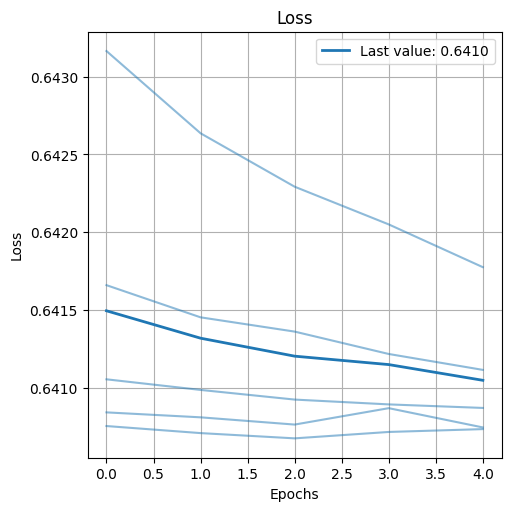

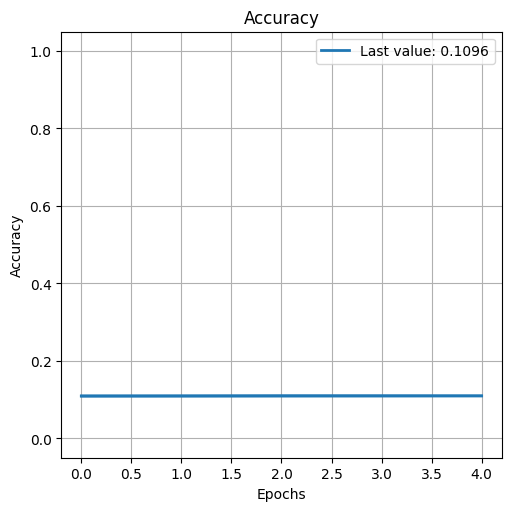

In [55]:
sub_grade_histories = []

for holdout in range(5):
    model = sub_grade_model
    sub_grade_histories.append(model.fit(X_train, y_train, epochs=5, verbose=0))

plot_history(
    sub_grade_histories,
    path='Plots/sub_grade_plots',
    single_graphs=True,
    show_standard_deviation=False,
    show_average=True
)

plt.close()

# Predicting Interest Rate

In [31]:
y = loan_df[['int_rate']] # in double brackets for y scaling testing
# X = loan_df[['home_ownership', 'annual_inc', 'loan_amnt', 'term', 'dti', 'mort_acc', 'open_acc',
#              'emp_length', 'tot_cur_bal', 'revol_util', 'acc_now_delinq']]

X = loan_df[['annual_inc', 'dti', 'loan_amnt', 'term', 'sub_grade', 'revol_util', 'acc_now_delinq', 'loan_status', 
            'pub_rec_bankruptcies', 'purpose', 'home_ownership']]

# ['emp_length', 'total_il_high_credit_limit', 'tot_cur_bal', 'mort_acc', 'num_accts_ever_120_pd', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim']
    # temporarily removed for testing cleaned dataset

In [32]:
# # drop rows with null values in any column - will be around 2000 rows

# get column names from X
column_names = X.columns

# loop through X to drop the rows that have nulls and apply the same drops to y
for column in column_names:
    # temp list to hold index values that have nulls in each column
    null_list = list(X.query(f'{column} != {column}').index)
    # drop from X
    X = X.dropna(axis='index', subset=[f'{column}'])
    # drop from y
    y = y.drop(index=null_list)

### Scale and one-hot-encode the data

In [33]:
# scale the numerical data and put it in a dataframe
scaledData = StandardScaler().fit_transform(X[['annual_inc', 'dti', 'loan_amnt', 'revol_util', 'acc_now_delinq', 'pub_rec_bankruptcies']])
scaledDF = pd.DataFrame(scaledData, columns = ['annual_inc', 'dti', 'loan_amnt', 'revol_util', 'acc_now_delinq', 'pub_rec_bankruptcies'])

In [34]:
# one-hot-encode the string data and put it in a dataframe
dummiesDF = pd.get_dummies(X[['term', 'sub_grade', 'loan_status', 'purpose', 'home_ownership']], dtype='float')
dummiesDF = dummiesDF.reset_index(drop=True)

In [35]:
# concat the two dataframes
scaledDF = pd.concat([scaledDF, dummiesDF], axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(scaledDF, y, random_state=1)

### Train the model

In [37]:
interest_model = tf.keras.models.Sequential()
interest_model.add(tf.keras.layers.Dense(units=50, input_dim=69, activation='sigmoid'))
interest_model.add(tf.keras.layers.Dense(units=25, activation='sigmoid'))
interest_model.add(tf.keras.layers.Dense(units=12, activation='sigmoid'))
interest_model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [38]:
# train the model and check accuracy using the R2 Score. Mean Absolute Percentage Error is also included.
interest_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['R2Score', 'mean_absolute_percentage_error'])

# test on 5 epochs
fit_interest_model = interest_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
21941/21941 [==============================] - 21s 932us/step - loss: 10.2804 - r2_score: 0.6164 - mean_absolute_percentage_error: 10.8927
Epoch 2/5
21941/21941 [==============================] - 20s 931us/step - loss: 0.1750 - r2_score: 0.9935 - mean_absolute_percentage_error: 2.8825
Epoch 3/5
21941/21941 [==============================] - 20s 926us/step - loss: 0.1716 - r2_score: 0.9936 - mean_absolute_percentage_error: 2.8485
Epoch 4/5
21941/21941 [==============================] - 20s 933us/step - loss: 0.1706 - r2_score: 0.9936 - mean_absolute_percentage_error: 2.8351
Epoch 5/5
21941/21941 [==============================] - 21s 936us/step - loss: 0.1694 - r2_score: 0.9937 - mean_absolute_percentage_error: 2.8271


In [39]:
#show_history(fit_interest_model) # single_graphs=True        temporarily commented for a full run
#plt.close()

In [40]:
# export model to keras file
    # using keras over hdf5 because hdf5 is now legacy
interest_model.save('Models/interest_model.keras')

In [41]:
interest_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                3500      
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                                 
 dense_8 (Dense)             (None, 12)                312       
                                                                 
 dense_9 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5100 (19.92 KB)
Trainable params: 5100 (19.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
model_loss, model_r2score, mean_abs_perc_err = interest_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, R2 Score: {model_r2score}, Mean Absolute Percentage Error: {mean_abs_perc_err}")

7314/7314 - 5s - loss: 0.1685 - r2_score: 0.9937 - mean_absolute_percentage_error: 2.7500 - 5s/epoch - 718us/step
Loss: 0.1685396134853363, R2 Score: 0.9936814904212952, Mean Absolute Percentage Error: 2.7500076293945312


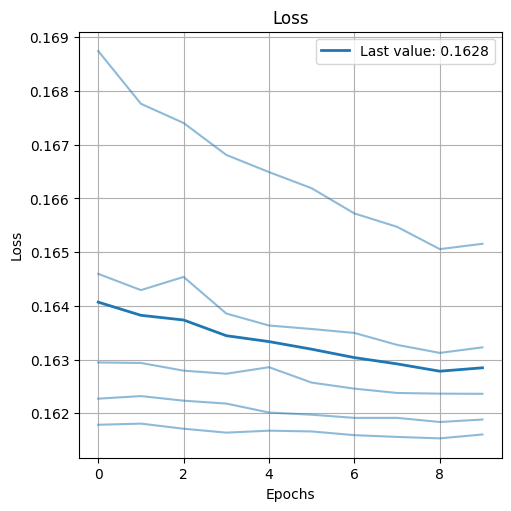

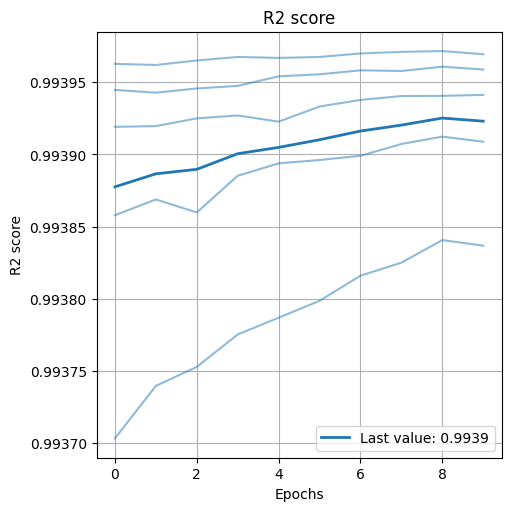

In [43]:
# use plot_keras_history to easily plot metrics scores

# list to hold histories
interest_histories = []

# loop to run training and append histories to the list
for holdout in range(5):
    model = interest_model
    interest_histories.append(model.fit(X_train, y_train, epochs=10, verbose=0))

# plot the histories using matplotlib
plot_history(
    interest_histories,
    path='Plots/interest_plots',
    single_graphs=True,
    show_standard_deviation=False,
    show_average=True
)

plt.close()